In [ ]:
!nvidia-smi

Tue May 26 08:25:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |   1451MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# **Building a GAN to generate the MNIST dataset**

# Task1: Loading the dataset and Creating the input neural layer

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import layers

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

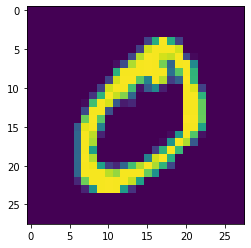

In [ ]:
plt.imshow(train_images[1])

In [ ]:
train_images.shape # as the mnist dataset only has one channel we need to introduce 1 in the last position of shape

(60000, 28, 28)

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1)
train_images = (train_images-127.5)/127.5    #normalizing the data between -1 and 1

In [ ]:
Buffer_size = train_images.shape[0]
Batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(Buffer_size).batch(Batch_size)

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

#Task2: Creating the Discriminator model

Set the input_shape to (286,384,1). Now the model expects an input with 4 dimensions. This means that you have to reshape your image with .reshape(n_images, 286, 384, 1). Now you have added an extra dimension without changing the data and your model is ready to run. Basically, you need to reshape your data to (n_images, x_shape, y_shape, channels).

The cool thing is that you also can use an RGB-image as input. Just change channels to 3.

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(7,(3,3), padding="same", input_shape=(28,28,1))) # the model expects the data with 4 params of shape (___, 28,28,1)
  model.add(tf.keras.layers.Flatten()) # we need to flatten the conv2d layer to pass it to dense layer
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(50, activation="relu"))
  model.add(tf.keras.layers.Dense(1))
  return model


In [ ]:
discriminator = make_discriminator_model()

In [ ]:
model_discriminator(np.random.rand(2,28,28,1).astype('float32')) # testing against random input

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.16351198],
       [-0.2070315 ]], dtype=float32)>

In [ ]:
# Adding an optimizer to our model
discriminator_optimizer = tf.optimizers.Adam(0.001)

real predictions are the prediction generated from the real images <br>
fake predictions are the prediction that come from the generator

In [ ]:
def get_discriminator_loss(real_predictions, fake_predictions):
  real_predictions = tf.sigmoid(real_predictions) # real prediction should be between 0 and 1
  fake_predictions = tf.sigmoid(fake_predictions)
  real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) # the real loss will be zero when all the real_predictions are 1 that is all real images are
                                                                                              # classified as real by the discriminator
  fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions) # the fake loss will be zero when all the fake_predictions are zero that is all fake images 
                                                                                                # generated by genrated are predicted as 0 by the discriminator
  return real_loss+fake_loss

# Task3: Creating the Generator

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  # now the model will take as input arrays of shape (*, 100)
  # and output arrays of shape (*, 7*7*256)
  model.add(layers.BatchNormalization()) # normalizing the data 
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # transpose of convolution is inverse of convolution
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model
  

In [ ]:
generator = make_generator_model()

In [ ]:
generator_optimizer = tf.optimizers.Adam(0.0001)

In [ ]:
def get_generator_loss(fake_predictions):
  fake_predictions = tf.sigmoid(fake_predictions)
  fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions), fake_predictions)
  return fake_loss

# Task4: Training

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            images = tf.cast(image_batch, tf.dtypes.float32)
            train_step(image_batch)


In [ ]:
def train_step(images):
  noise = tf.random.normal([Batch_size, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      gen_loss = get_generator_loss(fake_output)
      disc_loss = get_discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  print('generator loss:',np.mean(gen_loss))
  print('discriminator loss', np.mean(disc_loss))

In [ ]:
train(train_dataset,50)

Streaming output truncated to the last 5000 lines.
discriminator loss 0.56940883
generator loss: 2.1144662
discriminator loss 0.6731324
generator loss: 2.2581499
discriminator loss 0.47322816
generator loss: 2.824945
discriminator loss 0.55545896
generator loss: 3.2760935
discriminator loss 0.56425536
generator loss: 2.9001276
discriminator loss 0.49855572
generator loss: 2.73884
discriminator loss 0.528448
generator loss: 1.9026556
discriminator loss 0.75677496
generator loss: 2.3473024
discriminator loss 0.56483316
generator loss: 2.8287592
discriminator loss 0.4351243
generator loss: 3.2018113
discriminator loss 0.45432374
generator loss: 2.9848893
discriminator loss 0.48451918
generator loss: 2.5570512
discriminator loss 0.546959
generator loss: 2.250152
discriminator loss 0.59932506
generator loss: 2.7785163
discriminator loss 0.508785
generator loss: 2.6844594
discriminator loss 0.6834821
generator loss: 2.8732357
discriminator loss 0.5799549
generator loss: 2.8278098
discriminat

KeyboardInterrupt: ignored

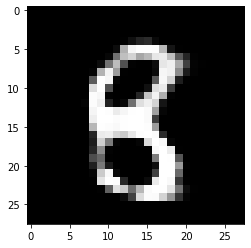

In [ ]:
# training stopped after 10 minutes 

plt.imshow(tf.reshape(generator(np.random.randn(1,100)), (28,28)), cmap='gray')

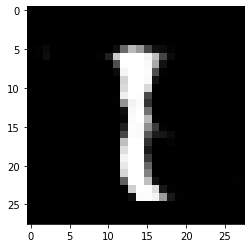